## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.unique()

array([0, 1])

In [7]:
df.query("converted==1")['user_id'].nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
df.group.unique(), df.landing_page.unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object))

In [9]:
df.query("group=='treatment' and landing_page=='old_page' or group=='control' and landing_page=='new_page'").count()[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
df2 = df.query("group=='treatment' and landing_page=='new_page' or group=='control' and landing_page=='old_page'")

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2.user_id.duplicated().sum()

1

In [15]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.duplicated('user_id',keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2.count()[0]

290585

In [18]:
df2.drop_duplicates(['user_id'],keep='first',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
df2.count()[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df2[df2['group']=='control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
df2[df2['group']=='treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
df2[df2['landing_page']=='new_page'].count()[0]/df2.count()[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on probability values calculated, it is evident that there are no to very minimal differences between the proportions of treatment group (11.88%) and control group (12.04%). This means that there is little evidence to suggest that the new page drives more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null Hypothesis:** $p_{old}$ >= $p_{new}$

**Alternative Hypothesis:** $p_{old}$ < $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [26]:
n_treat = df2[df2['group']=='treatment'].shape[0]
n_treat

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_control = df2[df2['group']=='control'].shape[0]
n_control

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted=np.random.binomial(1,p_new,n_treat)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted=np.random.binomial(1,p_old,n_control)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
new_page_converted.mean() - old_page_converted.mean()

-0.0010066865292153171

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [39]:
p_diffs = []

for _ in range(10000):
    newpcon=np.random.binomial(1,p_new,n_treat).mean()
    oldpcon=np.random.binomial(1,p_old,n_control).mean()
    p_diffs.append(newpcon-oldpcon)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

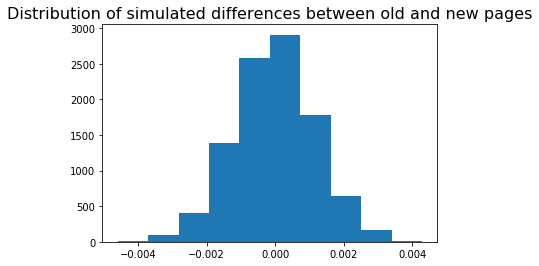

In [40]:
plt.hist(p_diffs)
plt.title('Distribution of simulated differences between old and new pages',fontsize=16);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [41]:
obs_diff = df2[df2['group']=='treatment'].converted.mean() - df2[df2['group']=='control'].converted.mean() 
obs_diff

-0.0015782389853555567

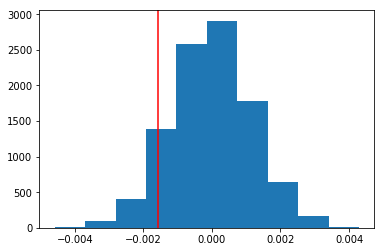

In [42]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff,color='red');

In [43]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.90939999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j, what was computed is scientifically known to be the p-value. The p-value is the probability of obtaining results at least as extreme as results actually observed. In other words, it is the evidence against our null hypothesis,$H_{0}$, since the null hypothesis is set by default to be true.**

**In this case, the computed p-value was found to be equal to 0.9059, which is sufficiently large to fail to reject the null hypothesis since it is far from the type I error threshold, denoted by α, which typically has a value of 0.05**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page' and converted==1").shape[0]
convert_new = df2.query("landing_page=='new_page' and converted==1").shape[0]
n_old = df2[df2['landing_page']=='old_page'].count()[0]
n_new = df2[df2['landing_page']=='new_page'].count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [45]:
zscore, p_val1= sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')

In [46]:
zscore, p_val1

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Applying the built-in methods returned a z-score of -1.31 and a p-value of 0.905. It is clear that this result validates the originally computed p-value in part j as they are close values. Consequently, we can say that since the p-value is large and too far from the type I error threshold, that the null hypothesis cannot be rejected hence old page leads to the same or more conversion than the new page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
# Adding intercept column
df2['intercept']=1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
# Creating dummy variables for group column
dummy = pd.get_dummies(df2['group'])
dummy=dummy.rename(columns={'treatment':'ab_page'})
dummy.drop('control',axis=1,inplace=True)
df2=df2.join(dummy)


In [49]:
df2.sample(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
114555,905740,2017-01-17 05:23:13.078275,treatment,new_page,0,1,1
74550,905600,2017-01-15 18:16:35.457514,treatment,new_page,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [50]:
import statsmodels.api as sm
lrm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result1 = lrm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [51]:
result1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-16 19:13 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with the ab_page is 0.1899, hence we still fail to reject the null hypothesis.**

**The reason why the p-value computed in this part differs to the one calculated in A/B testing (part 2) is because this part is a two-tailed test whereas part 2 is a one-sided test. This contrast can be seen when stating the hypotheses, such that:**

1. A/B Test - Part 2:

**Null Hypothesis:** $p_{old}$ >= $p_{new}$

**Alternative Hypothesis:** $p_{old}$ < $p_{new}$

2. Logistic Regression Model - Part 3:

**Null Hypothesis:** $p_{old}$ = $p_{new}$

**Alternative Hypothesis:** $p_{old}$ ≠ $p_{new}$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Investigating how additional factors may influence the conversion rate is certainly beneficial since this can be very insightful into how each explanatory variable affect the response. Moreover, this allows us to determine the magnitude of the influence each factor has over the response variable, in our case the conversion rate.**

**On the other hand, using all of the explanatory variables or factors together in our model may lead to inaccurate results and thereby making erroneous conclusions. Relationships that may exist between these factors will undermine to the model and as a result lead to inaccurate predictions of the response variable.**  

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [52]:
dfc = pd.read_csv('countries.csv')

In [53]:
dfc.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [54]:
df3 = df2.set_index('user_id')
dfc1 = dfc.set_index('user_id')

In [55]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0


In [56]:
df3 = df3.merge(dfc1,on='user_id',how='inner')

In [57]:
df3.head(2)

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US


In [58]:
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [59]:
df3_mod = pd.get_dummies(df3['country'])
df3_mod = df3.join(df3_mod)
df3_mod.head(2)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1


In [60]:
lrm2 = sm.Logit(df3_mod['converted'],df3_mod[['intercept','UK','US','ab_page']])
result2 = lrm2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-16 19:15 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

**The summary above indicates that p-values show insignificant statistical differences, hence we reject the null hypothesis**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [61]:
df3_mod['US_np'] = df3_mod['ab_page'] * df3_mod['US']
df3_mod['UK_np'] = df3_mod['ab_page'] * df3_mod['UK']
df3_mod.sample(2)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_np,UK_np
user_id,,,,,,,,,,,,
683372,2017-01-16 14:12:34.487054,control,old_page,0,1,0,US,0,0,1,0,0
653125,2017-01-23 07:12:15.073922,control,old_page,0,1,0,US,0,0,1,0,0


In [63]:
lrm3 = sm.Logit(df3_mod['converted'],df3_mod[['intercept','US','UK','US_np','UK_np']])
result3 = lrm3.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [64]:
result3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-03-16 19:19 AIC:              212782.3422
No. Observations:   290584           BIC:              212835.2404
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0511    0.0277    1.8414  0.0656  -0.0033   0.1054
UK             0.0453    0.0306    1.4806  0.1387  -0.0147   0.1053
US_np         -0.0206    0.0137   -1.5052  0.1323  -0.0473   0.0062
UK_np          0.0108    0.0228    0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**The summary above proves that the interaction between countries and new page has no statistical significance meaning that we fail to reject the null hypothesis once again. Finally, we can safely say that the new page does not lead to more conversions.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [99]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0